# Getting started with PUDL
This notebook is meant to help get you up and running with the PUDL database, so you can play with it! There's a huge amount of interesting data already available within the database. However, it has not yet been fully vetted for accuracy or even sanity -- so for now this is an alpha release, certain to have some bugs and inconsistencies within it.  But we'll find and fix those issues faster if other people are playing with the data too.

We also need to do a round of name and unit standardization, and more fully document which data is stored where to make the database easier for others to work with.

# Importing external code.
We need to import a bunch of outside code to do our work here.  Sometimes we import entire packages (like `numpy` and `pandas`) and give them a nickname like `np` or `pd` to keep things simpler.

In [1]:
import sys
import os
import numpy as np
import pandas as pd

# Setting up external pre-requisites.
After you've cloned the git repository and installed the other software packages that PUDL depends on (see the top level `REQUIREMENTS.md` file) you'll still need to do a little bit of setup before the system is ready to load all of the for analysis and plotting.

## Downloading original data.
PUDL is set up to take the raw data, which you can download direclty from FERC and EIA (and eventually other agencies as well) in the form that they provide, and convert it into a single unified database for easier use.  These data files are too large to store in the repository, so there are a couple of shell scripts that download it directly from the federal agencies websites, and put it where it needs to be for the PUDL software to interact with it.  Each data source has its own shell script for now.  To run the scripts and get the data, from the top level repository directory you `cd` down into the data directory for the agency and form you're getting the data for, and run the script. E.g.:
```
cd data/ferc/form1
sh ./get_ferc1.sh
```
or
```
cd data/eia/form923
sh ./get_eia923.sh
```
It's severeal gigabytes of data, so it'll take a while. Go make yourself a snack.

## Creating databases and users.
The other main thing you'll need to do is create a database superuser named `catalyst` and a couple of empty postgres databases on your local machine, which will receive the data.  The first should be called `ferc1` and the second should be called `pudl`.  If you're going to be doing development on the code, you should also make `ferc1_test` and `pudl_test` databases, which are used to run the test cases (so you don't have to wipe out your "production" database which you might be using for analysis just to run the tests.)

It's not ideal that the database user is a superuser, but for now it's required, because we're using the native postgresql `COPY FROM` command to ingest some huge CSV files very efficiently... and that command requires a superuser account (since it can be used to inject arbitrary data into the DB.)

# Populating the PUDL database.
Once you've got the raw data downloaded and a couple of empty databases ready to receive it, you'll need to run a script which extracts the original data from the files it's distributed in by those federal agencies, parses it and cleans it up a bit, and loads it into the database on your local machine.

The easiest way to do all of that is to run the initialization script, which can be found in the top level `scripts` directory that ought to have been downloaded when you cloned the repository.  To run that script at the command line, you `cd` into the `scripts` directory and call `python init_pudl.py`

You should see some output from the script, telling you about its progress.  By default, it will load all of the data that is currently working. That means years 2007-2015 for FERC Form 1, and 2009-2015 for the EIA923.  The whole process will likely take about 20 minutes, and the database will take up about 2GB of space once it's done. If you want to just do a small subset of the data to test whether the setup is working, check out the help message on the script by calling `python init_pudl.py -h`.

# Importing our own code
Assuming the data loading went well, now it's time to need to tell Python where to look to find our code. Python has a list of directories that it looks in by default, but our little project isn't in that list, because we're not yet ready to package it up for installation on a user's system.  So we need to tell Python exactly where to find it it. This is what `sys.path.append()` does in the code cell below. Right now this tells Python to look three directories above the current directory (`../../../` for the main PUDL module directory, which is what you got when you cloned our `git` repository. If you're running a notebook from a different directory, you'll need to change that path.

Once Python knows to look in the `pudl` project folder, it will let you import `pudl` modules just like any other Python module.  Here we're pulling in all the individual modules we've created so far, so everything is available to play with.

In [2]:
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923
from pudl import models, models_ferc1, models_eia923
from pudl import settings, constants

# Connecting to our databases.
The FERC Form 1 (`ferc1`) database that you created above is just a temporary container used to migrate the Form 1 data out of the FoxPro database that FERC uses. The main database that all the data eventually lands in is (`pudl`). In order to grab a connection to the database, so you can pull data into this notebook, you can use the shorthand function below:

In [3]:
pudl_engine  = pudl.db_connect_pudl()

# Selecting data from within PUDL
Once you've got the `pudl_engine` created, there are several different ways you can use it to extract information from within the PUDL database. If you're already familiar with SQL, the easiest is probably to use the built-in pandas dataframe method `read_sql()`.

The `fuel_receipts_costs_eia923` table contains information about fuel deliveries to power plants in the US. It contains hundreds of thousands of records, currently covering 2009 to 2015.

In [4]:
frc_eia923 = pd.read_sql('''SELECT * FROM fuel_receipts_costs_eia923''', pudl_engine)

# What kind of data do we have here?
Once the dataframe has been populated with data from the database, we can look and see what all the fields (or columns) in the dataframe are called, giving us an indication of what the information is.

In [5]:
frc_eia923.columns

Index(['fuel_receipt_id', 'plant_id', 'report_date', 'contract_type',
       'contract_expiration_date', 'energy_source', 'fuel_group',
       'coalmine_id', 'supplier', 'fuel_quantity', 'average_heat_content',
       'average_sulfur_content', 'average_ash_content',
       'average_mercury_content', 'fuel_cost', 'primary_transportation_mode',
       'secondary_transportation_mode', 'natural_gas_transport'],
      dtype='object')

# Organizing the pandas dataframes

Now that we've got a data frame filled with data we pulled out of our database, we can organize it however we want to do analysis or make figures. Just as an example, let's prepare the data to make a figure showing the distribution of fuel heat content per unit delivered for coal and natural gas.

First we create masks which allow us to subselect based on what kind of fuel each record reports.  Then we drop any records with NA values for `average_heat_content` and exclude any records that have a reported heat content of zero (or less).

In [6]:
coal_mask = frc_eia923['fuel_group'] == 'Coal'
coal_frc = frc_eia923[coal_mask]
coal_frc = coal_frc.dropna(subset=['average_heat_content'])
coal_frc = coal_frc[coal_frc.average_heat_content > 0]

gas_mask = frc_eia923['fuel_group'] == 'Natural Gas'
gas_frc  = frc_eia923[gas_mask]
gas_frc = gas_frc.dropna(subset=['average_heat_content'])
gas_frc = gas_frc[gas_frc.average_heat_content > 0]

# Plotting the data

With our coal and gas dataframes ready to go, now we can assemble a simple figure, and see what the heat content distributions look like using Matplotlib.

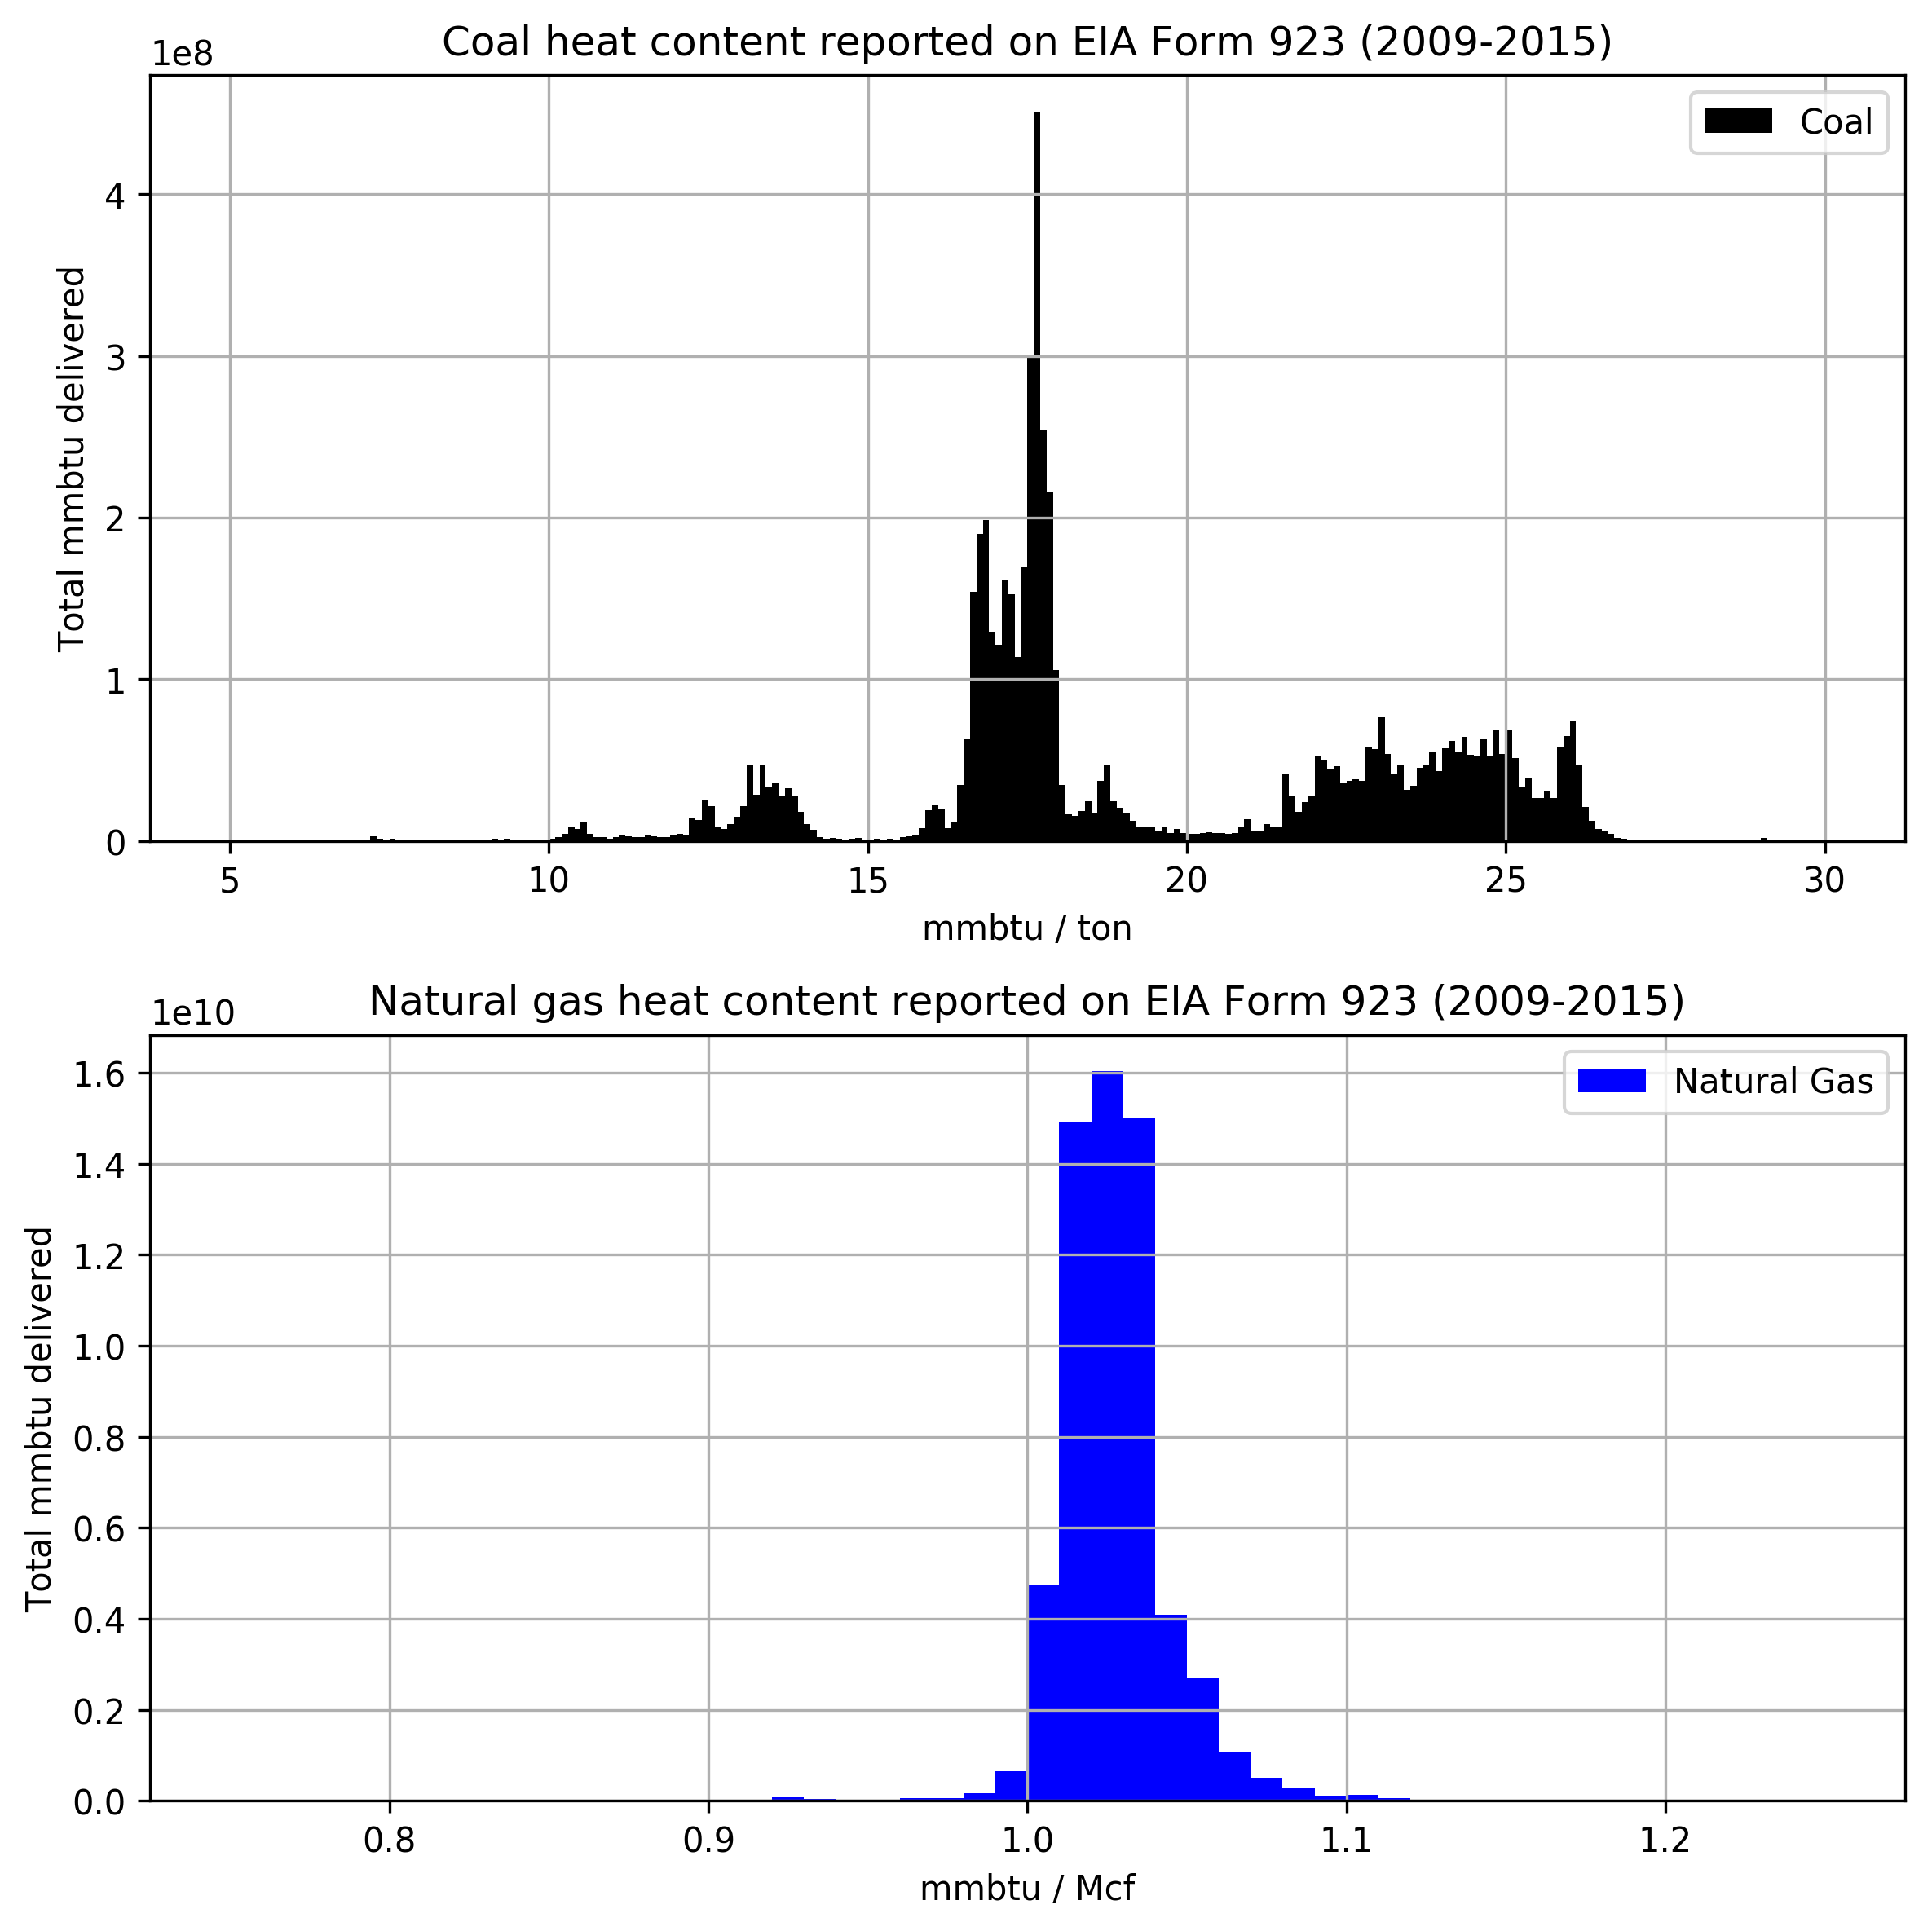

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (coal_ax, gas_ax) = plt.subplots(2)

fig.set_dpi(300)
fig.set_figwidth(8)
fig.set_figheight(8)

coal_ax.set_title("Coal heat content reported on EIA Form 923 (2009-2015)")
coal_ax.grid()
coal_ax.set_xlabel('mmbtu / ton')
coal_ax.set_ylabel('Total mmbtu delivered')
coal_ax.hist(coal_frc.average_heat_content, weights=coal_frc.fuel_quantity,
             bins=250, range=(5,30), label='Coal', color='black')
coal_ax.legend()

gas_ax.set_title("Natural gas heat content reported on EIA Form 923 (2009-2015)")
gas_ax.grid()
gas_ax.set_xlabel('mmbtu / Mcf')
gas_ax.set_ylabel('Total mmbtu delivered')
gas_ax.hist(gas_frc.average_heat_content, weights=gas_frc.fuel_quantity,
            bins=50, range=(0.75,1.25), label='Natural Gas', color='blue')
gas_ax.legend()

plt.tight_layout()
plt.show()